# Setting

In [1]:
from pf_utils import DataManager, FinancialRatios, BacktestManager
from pf_widgets import WidgetUniverse, WidgetTransaction

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
path_data = 'data'

# Universe

In [3]:
WidgetUniverse

In [4]:
# universe and file
#uv_k200 = ['kospi200', 'kospi200_prices_000306_240707.csv']
uv_k200 = ['kospi200', 'kospi200_prices_100104_240707.csv']
uv_k2hl = ['krx', 'kospi200_prices_bt_040102_241023.csv']
uv_krx = ['krx', 'krx_prices.csv']

## KRX

In [5]:
krx = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_krx))
)
krx.upload()

2712 assets from 2019-01-02 to 2024-10-08 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1),
    interval=5, pause_duration=1, msg=False
)
#krx.download(**kw) if WidgetUniverse.values(0) else None

In [7]:
df_krx = krx.df_prices
assetnames_krx = krx.get_names()

ERROR from get_names: '164060'


### KOSPI

In [8]:
from pf_utils import KRXDownloader
market = 'KOSPI'
krxd = KRXDownloader(None)
krxd.get_tickers(market)
assets_kospi = krxd.tickers

In [9]:
df_kospi = df_krx[df_krx.columns.intersection(assets_kospi)]

## KOSPI200

In [5]:
k200 = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k200))
)
k200.upload()

200 assets from 2010-01-04 to 2024-07-05 uploaded.
df_prices updated


In [6]:
kw = dict(
    n_years=3, 
    close_today = WidgetUniverse.values(1)
)
k200.download(**kw) if WidgetUniverse.values(0) else None

In [7]:
df_k200 = k200.df_prices
assetnames_k200 = k200.get_names()

### Data Size

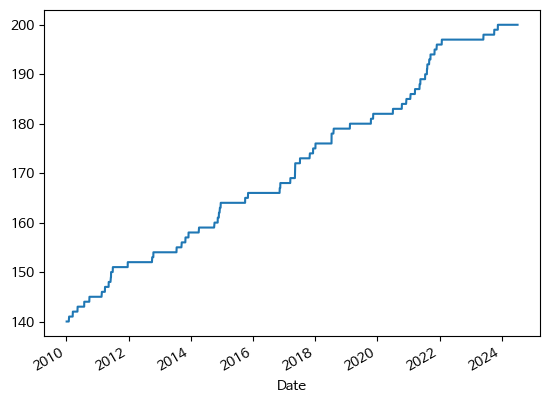

In [8]:
_ = df_k200.unstack().dropna().groupby('Date').count().plot()

In [9]:
start = '2020'
df_k200.loc[start:].dropna(axis=1).columns.size

182

In [10]:
df_k200 = df_k200.loc[start:]
len(df_k200)

1113

## K2HL

In [5]:
k2hl = DataManager(
    path = path_data,
    **dict(zip(['universe', 'file'], uv_k2hl))
)
k2hl.upload()

426 assets from 2004-01-02 to 2024-10-23 uploaded.
df_prices updated


In [6]:
df_k2hl = k2hl.df_prices
assetnames_k2hl = k2hl.get_names()

ERROR from get_names: '060000'


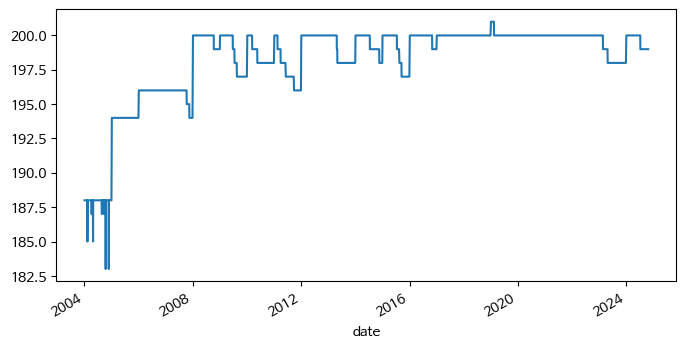

In [7]:
_ = df_k2hl.notna().sum(axis=1).plot(figsize=(8,4))

## Financial Ratio

In [19]:
WidgetUniverse

In [20]:
file = 'kospi200_ratios_170531_240930.csv'
fr = FinancialRatios(file, path_data)

Financial ratios of 171 stocks from 2017-05-31 to 2024-09-30 loaded


In [21]:
start = '2023-01-01'
tickers = df_k200.columns.to_list()
kw = dict(
    freq = 'd',
    close_today = WidgetUniverse.values(1)
)
fr.download(tickers, start, **kw) if WidgetUniverse.values(0) else None

*Reshape for backtest*

In [22]:
df_p = fr.util_reshape(df_k200)

fratios_dict = dict()
for r in ['PER', 'PBR']:
    df = fr.interpolate(df_p, r)
    fratios_dict[r] = fr.util_reshape(df, stack=False)

PER interpolated from 2020-01-02 to 2024-07-05
PBR interpolated from 2020-01-02 to 2024-07-05


# Momentum

## Parameter study

In [ ]:
n_val = 200
lookback = 260
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [ ]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k200
)

### Cross-validate

In [14]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [10,20],
    p_freq = [20,40,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg10/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 10,
 'freq': 20}

In [15]:
from itertools import product

p_args = dict(
    p_n_assets = [5],
    p_lookback = [6,12],
    p_lag = [10,20],
    p_freq = [20,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb6/lg10/f20',
 'n_assets': 5,
 'lookback': 6,
 'lag': 10,
 'freq': 20}

In [16]:
bm = BacktestManager(df_train, **kwargs_bm)

200 assets from 2020-01-02 to 2023-09-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [17]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True
)
bm.build_batch(*kwa_list, **kwargs_build)

In [18]:
bm.cross_validate(n_sample=20)

### Visualize

In [24]:
file = 'param_momentum_k200.csv'

In [ ]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

*Load param study*

In [26]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_k200.csv


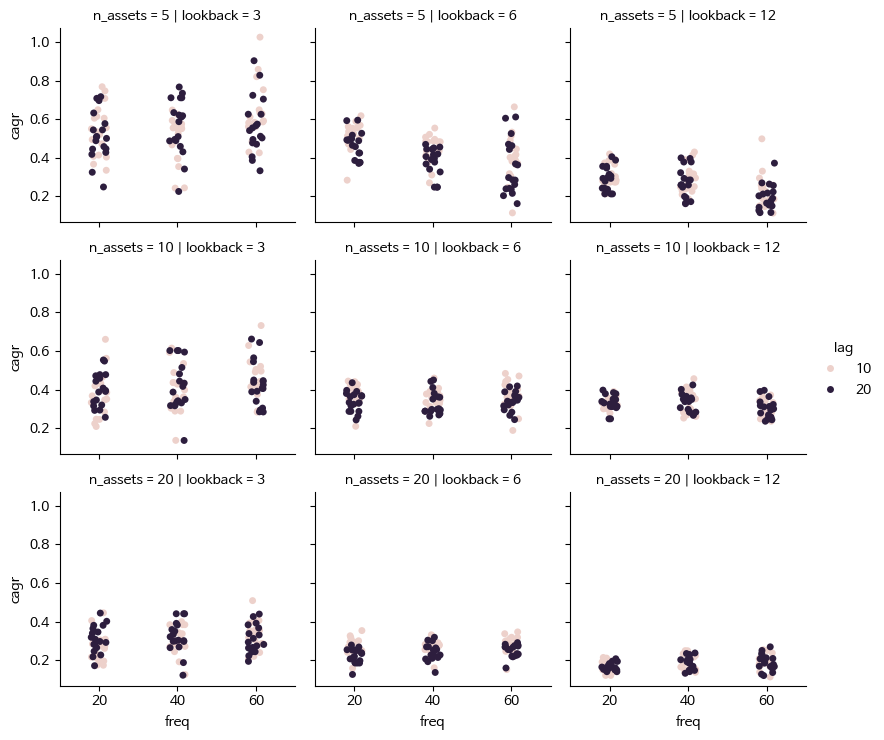

In [27]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}
#kw = {'x':'freq', 'col':'n_assets', 'row':'lookback', 'hue':'lag'}
#kw = {'x':'freq', 'col':'n_assets', 'row':'lookback', 'kind':'box'}
kw = {'x':'freq', 'row':'n_assets', 'col':'lookback', 'hue':'lag'}

_ = bm.catplot(data=df_cv, y='cagr', height=2.5, aspect=1.1, **kw)

### Validation

In [64]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=3, lag=10)
bm.benchmark_ticker(**lags)

200 assets from 2022-08-23 to 2024-07-05 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [65]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[5, 3, 10, 20], [20, 12, 20, 60], [5, 12, 5, 20]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 4 strategies: KODEX200, MOM:n5/lb3/lg10/f20, MOM:n20/lb12/lg20/f60, MOM:n5/lb12/lg5/f20


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]

Returning stats


,MOM:n5/lb3/lg10/f20,MOM:n5/lb12/lg5/f20,KODEX200,MOM:n20/lb12/lg20/f60
start,2022-08-22,2022-08-22,2022-08-22,2022-08-22
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,1.52734,0.846402,0.306273,0.204645
cagr,0.641851,0.388111,0.153591,0.104692
calmar,2.606932,1.630178,1.216436,0.98381
max_drawdown,-0.246209,-0.238079,-0.126263,-0.106415
avg_drawdown,-0.071619,-0.048359,-0.029611,-0.02516
avg_drawdown_days,21.347826,14.235294,23.181818,11.8
daily_vol,0.419157,0.307866,0.149205,0.106218
daily_sharpe,1.418745,1.240916,1.055589,1.013265


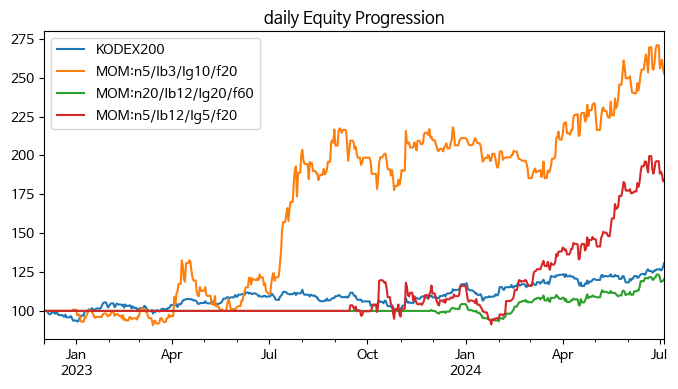

In [66]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(8,4))

## KOSPI

### Parameter study

In [ ]:
len(df_kospi)

In [ ]:
n_val = 200
lookback = 260
df = df_kospi
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [ ]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

#### Cross-validate

In [8]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [20],
    p_freq = [20, 60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg20/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 20,
 'freq': 20}

In [ ]:
bm = BacktestManager(df_train, **kwargs_bm)

In [ ]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True
)
bm.build_batch(*kwa_list, **kwargs_build)

In [59]:
bm.cross_validate(n_sample=20)

Cross-validating 18 strategies: MOM:n5/lb3/lg20/f20, MOM:n5/lb3/lg20/f60, ... , MOM:n20/lb12/lg20/f60


100%|███████████████████████████████████████████████████████████████| 19/19 [01:00<00:00,  3.17s/it]


18.0 mins elapsed, 0.0 secs paused (0.0%)


#### Visualize

In [ ]:
file = 'param_momentum_kospi.csv'

In [60]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_momentum_kospi.csv saved


*Load param study*

In [35]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_kospi.csv


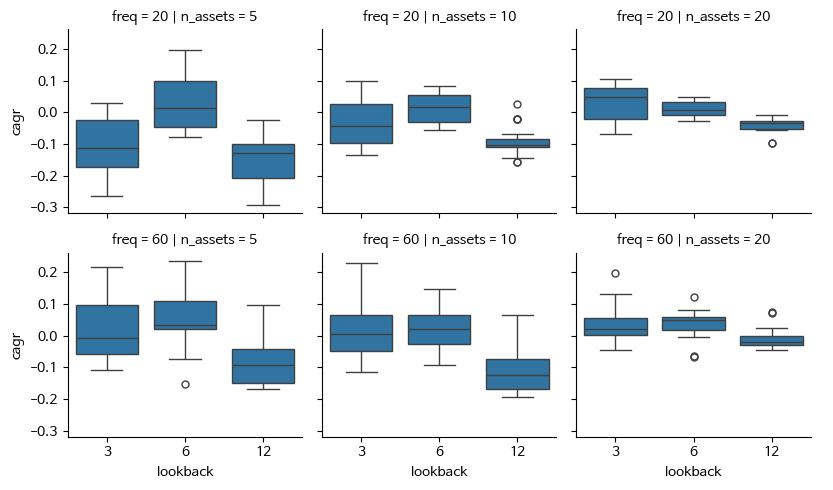

In [36]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback'}
kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'kind':'box'}

_ = bm.catplot(data=df_cv, y='cagr', height=2.5, aspect=1.1, **kw)

#### Validation

In [37]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=3, lag=20)
bm.benchmark_ticker(**lags)

938 assets from 2022-11-22 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [38]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[20, 3, 20, 20], [20, 12, 20, 60]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 3 strategies: KODEX200, MOM:n20/lb3/lg20/f20, MOM:n20/lb12/lg20/f60


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]

Returning stats


,KODEX200,MOM:n20/lb12/lg20/f60,MOM:n20/lb3/lg20/f20
start,2022-11-21,2022-11-21,2022-11-21
end,2024-10-08,2024-10-08,2024-10-08
total_return,0.134857,-0.016118,-0.189618
cagr,0.069572,-0.008602,-0.10576
calmar,0.422206,-0.029725,-0.262138
max_drawdown,-0.164782,-0.289384,-0.403454
avg_drawdown,-0.027873,-0.041869,-0.119288
avg_drawdown_days,19.269231,13.214286,105.2
daily_vol,0.16847,0.207013,0.297248
daily_sharpe,0.496304,0.061686,-0.238494


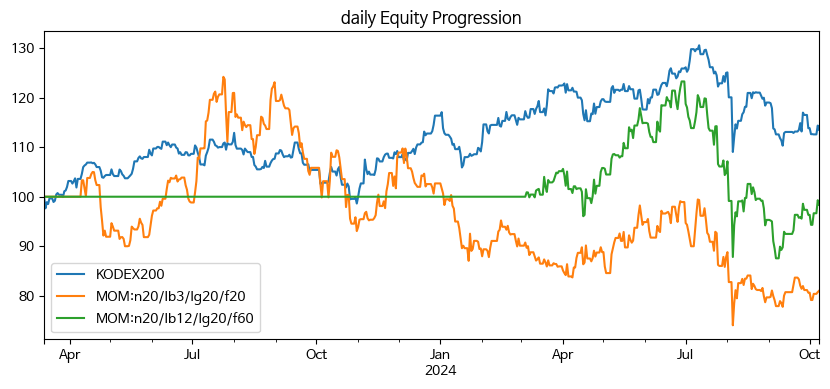

In [39]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

## K2HL

### Parameter study

In [8]:
len(df_k2hl)

5142

In [9]:
df = df_k2hl.ffill()
n_val = 500
lookback = 260
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [10]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_k2hl
)

#### Cross-validate

In [11]:
from itertools import product

p_args = dict(
    p_n_assets = [5,10,20],
    p_lookback = [3,6,12],
    p_lag = [10,20],
    p_freq = [20,60]
)
p_comb = list(product(*p_args.values()))
params = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]
params[0]

{'name': 'MOM:n5/lb3/lg10/f20',
 'n_assets': 5,
 'lookback': 3,
 'lag': 10,
 'freq': 20}

In [12]:
bm = BacktestManager(df_train, **kwargs_bm)

426 assets from 2004-01-02 to 2022-10-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [13]:
kwa_list = params
kwargs_build = dict(
    select='Momentum', weigh='Equally', 
    reset_portfolios=True
)
bm.build_batch(*kwa_list, **kwargs_build)

In [ ]:
kw_batch = dict(size_batch=5, path_batch=path_data)
bm.cross_validate(n_sample=20, **kw_batch)

Cross-validating 36 strategies: MOM:n5/lb3/lg10/f20, MOM:n5/lb3/lg10/f60, ... , MOM:n20/lb12/lg20/f60
0 jobs done before


 56%|███████████████████████████████████                            | 10/18 [02:11<01:48, 13.58s/it]

#### Visualize

In [ ]:
file = 'param_momentum_kospi.csv'

In [60]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_momentum_kospi.csv saved


*Load param study*

In [35]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_kospi.csv


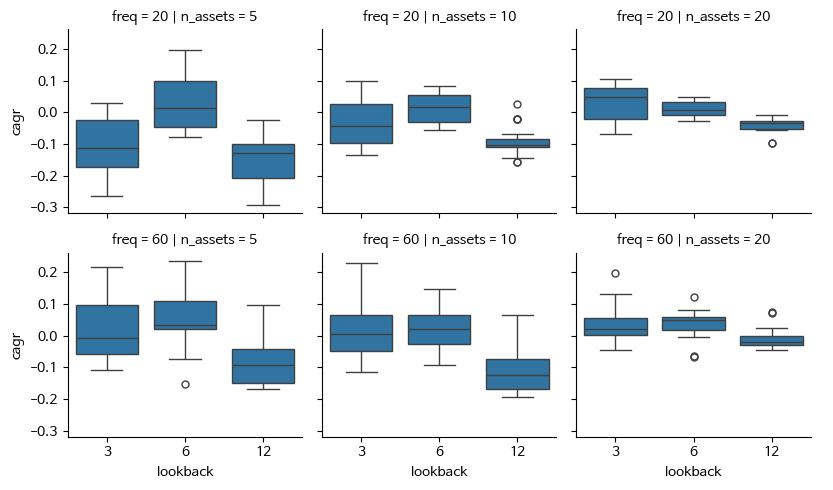

In [36]:
#kw = {'x':'freq', 'row':'n_assets', 'col':'lookback'}
kw = {'x':'lookback', 'row':'freq', 'col':'n_assets', 'kind':'box'}

_ = bm.catplot(data=df_cv, y='cagr', height=2.5, aspect=1.1, **kw)

#### Validation

In [37]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=3, lag=20)
bm.benchmark_ticker(**lags)

938 assets from 2022-11-22 to 2024-10-08 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [38]:
# n_assets, lookback(M), lag(D), freq(D)
p_comb = [[20, 3, 20, 20], [20, 12, 20, 60]]
kwa_list = [{'name':f'MOM:n{x[0]}/lb{x[1]}/lg{x[2]}/f{x[3]}',
           'n_assets':x[0], 'lookback':x[1], 'lag':x[2], 'freq':x[3]} 
            for x in p_comb]

Backtesting 3 strategies: KODEX200, MOM:n20/lb3/lg20/f20, MOM:n20/lb12/lg20/f60


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.70it/s]

Returning stats


,KODEX200,MOM:n20/lb12/lg20/f60,MOM:n20/lb3/lg20/f20
start,2022-11-21,2022-11-21,2022-11-21
end,2024-10-08,2024-10-08,2024-10-08
total_return,0.134857,-0.016118,-0.189618
cagr,0.069572,-0.008602,-0.10576
calmar,0.422206,-0.029725,-0.262138
max_drawdown,-0.164782,-0.289384,-0.403454
avg_drawdown,-0.027873,-0.041869,-0.119288
avg_drawdown_days,19.269231,13.214286,105.2
daily_vol,0.16847,0.207013,0.297248
daily_sharpe,0.496304,0.061686,-0.238494


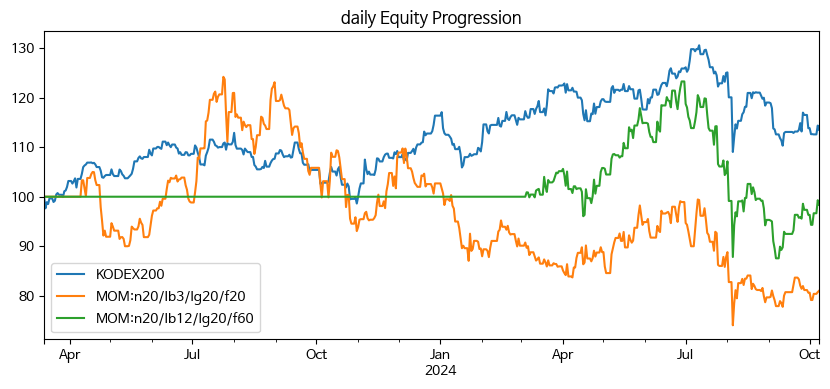

In [39]:
kwargs_build = dict(
    select='Momentum', weigh='Equally'
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(10,4))

# Contrarian

## Parameter study

In [69]:
n_val = 200
lookback = 260
df = df_k200
df_train = df.iloc[:-n_val]
df_val = df.iloc[-n_val-lookback:]

In [70]:
kwargs_bm = dict(
    initial_capital = 1e8,
    commissions = 0,
    align_axis = None, 
    days_in_year = 246,
    asset_names = assetnames_krx
)

In [71]:
convert_args = lambda p: [{**x, 'df_ratio': fratios_dict[x['df_ratio']], 
                           'lookback':f'{x['lookback']} days'} for x in p]

### Cross-validate

In [43]:
from itertools import product

p_args = dict(
    p_metric = ['PER'],
    p_n_assets = [5,10,20],
    p_freq = [130,250,500],
    p_lookback = [0, 10, 30, 60] # days
)
p_comb = list(product(*p_args.values()))
params = [{'name':'{}:n{}/f{}/lb{}'.format(*x),
           'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
            for x in p_comb]
params[0]

{'name': 'PER:n5/f130/lb0',
 'df_ratio': 'PER',
 'n_assets': 5,
 'freq': 130,
 'lookback': 0}

In [44]:
bm = BacktestManager(df_train, **kwargs_bm)

200 assets from 2020-01-02 to 2023-09-07 uploaded.
running self.util_check_days_in_year to check days in a year


In [45]:
kwa_list = convert_args(params)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

In [46]:
bm.cross_validate(n_sample=20)

Cross-validating 36 strategies: PER:n5/f130/lb0, PER:n5/f130/lb10, ... , PER:n20/f500/lb60


100%|███████████████████████████████████████████████████████████████| 20/20 [00:18<00:00,  1.09it/s]


10.1 mins elapsed, 0.0 secs paused (0.0%)


### Visualize

In [47]:
file='param_per_k200.csv'

In [48]:
f = dict(file=file, path=path_data)
df_cv = bm.get_cat_data(params, **f)

data/param_per_k200.csv saved


*Load param study*

In [21]:
bm = BacktestManager
df_cv = bm.catplot(file, path=path_data)

Returning data/param_momentum_k200.csv


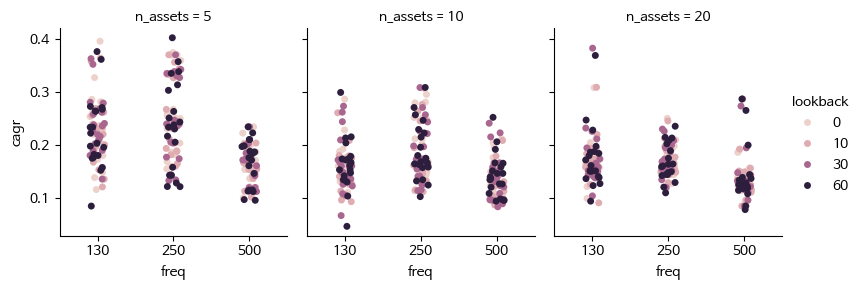

In [55]:
#kw = {'x':'lookback', 'col':'n_assets', 'row':'freq', 'kind':'box'}
#kw = {'x':'freq', 'col':'n_assets', 'row':'lookback', 'kind':'box'}
kw = {'x':'freq', 'col':'n_assets', 'hue':'lookback'}

_ = bm.catplot(data=df_cv, y='cagr', height=3, aspect=.9, **kw)

### Validation

In [72]:
bm = BacktestManager(df_val, **kwargs_bm)

lags = dict(lookback=0, lag=0)
bm.benchmark_ticker(**lags)

200 assets from 2022-08-23 to 2024-07-05 uploaded.
running self.util_check_days_in_year to check days in a year
Benchmark is KODEX200


In [73]:
# df_ratio, n_assets, freq(D), lookback(D)
p_comb = [['PER', 5, 250, 0], ['PER', 10, 250, 0], ['PER', 5, 250, 5]]
kwa_list = [{'name':'{}:n{}/f{}/lb{}'.format(*x),
             'df_ratio':x[0], 'n_assets':x[1], 'freq':x[2], 'lookback':x[3]} 
             for x in p_comb]

Backtesting 4 strategies: KODEX200, PER:n5/f250/lb0, PER:n10/f250/lb0, PER:n5/f250/lb5


100%|█████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.22it/s]

Returning stats


,KODEX200,PER:n10/f250/lb0,PER:n5/f250/lb0,PER:n5/f250/lb5
start,2022-08-22,2022-08-22,2022-08-22,2022-08-22
end,2024-07-05,2024-07-05,2024-07-05,2024-07-05
total_return,0.29642,0.278896,0.203593,0.203593
cagr,0.14893,0.140598,0.104176,0.104176
calmar,1.164546,0.801227,0.479045,0.479045
max_drawdown,-0.127886,-0.175478,-0.217466,-0.217466
avg_drawdown,-0.035878,-0.059951,-0.07883,-0.07883
avg_drawdown_days,27.727273,49.153846,72.555556,72.555556
daily_vol,0.169941,0.224314,0.280934,0.280934
daily_sharpe,0.921758,0.712501,0.500503,0.500503


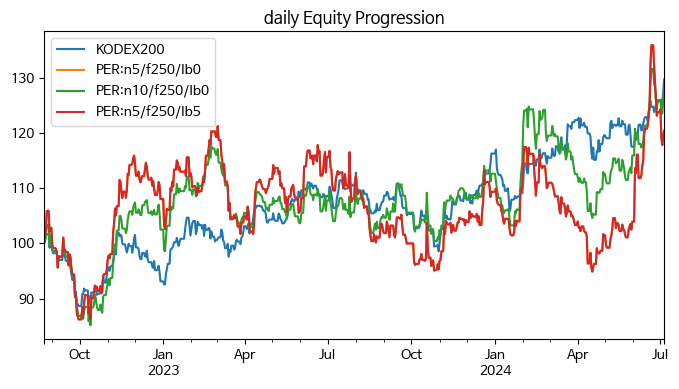

In [74]:
kwa_list = convert_args(kwa_list)

kwargs_build = dict(
    select='F-ratio', weigh='Equally', ratio_descending=False
)
bm.build_batch(*kwa_list, **kwargs_build)

bm.run(stats_sort_by='cagr', figsize=(8,4))